In [1]:
#import require python classes and packages
from string import punctuation
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from nltk.stem import PorterStemmer
import os
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer #===========loading bert sentence model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #loading tfidf vector
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 #loading CHI2 class
from sklearn.tree import DecisionTreeClassifier
from scipy.spatial import distance
from numpy import dot
from numpy.linalg import norm
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define object to remove stop words and other text processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [3]:
#define global variables to store labels, title and title + description
title_textdata = []
desc_textdata = []
labels = []

In [4]:
#define function to clean text by removing stop words and other special symbols
def cleanText(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [ps.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [8]:
#load & display dataset values
dataset = pd.read_csv("Dataset/JobsDataset.csv")
class_label, count = np.unique(dataset['Query'], return_counts=True)
dataset

,ID,Query,Job Title,Description
0,1,Data Scientist,Junior Data Scientist Apprenticeship,Job Description As a Junior Data Scientist at ...
1,2,Data Scientist,"HBO Data Scientist, Content Science",OVERALL SUMMARY As a Data Scientist on the Dat...
2,3,Data Scientist,Junior Data Scientist,The Team: The Data science team is a newly for...
3,4,Data Scientist,Jr Data Scientist,We now have a need for junior Data Scientist(s...
4,5,Data Scientist,"Data Scientist, Premium Content",Do you want to help guide the core business of...
...,...,...,...,...
9995,9996,Network Architect,Learning Architect,The opportunity Our customers understand that ...
9996,9997,Network Architect,Systems Architect,The NASA Ames Research Center has the requirem...
9997,9998,Network Architect,Hardware Architect,What You'll Do Distinguished Engineer with pro...
9998,9999,Network Architect,"Software Development Engineer, Full Stack – E...","Software Development Engineer, Full Stack – En..."


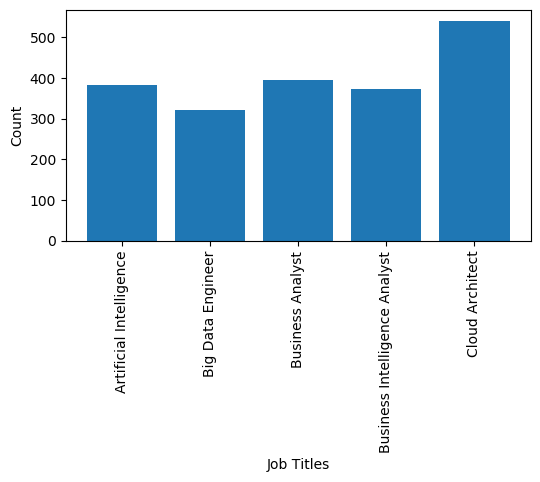

In [12]:
#find and plot graph of different jobs found in dataset
count = count[0:5]
class_label = class_label[0:5]
height = count
bars = class_label
y_pos = np.arange(len(bars))
plt.figure(figsize =(6, 3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Job Titles")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#function to get job label of give name
def getLabel(name):
    class_id = -1
    for i in range(len(class_label)):
        if class_label[i] == name:
            class_id = i
            break
    return class_id

In [14]:
#now read job details dataset and then convert to TFIDF vector and BERT vector
if os.path.exists("model/bert_title_desc.npy"):
    bert_desc_X = np.load("model/bert_title_desc.npy")#load bert title + description data
    Y = np.load("model/label.npy") #load training labels
    bert_title_X = np.load("model/bert_title.npy") #load bert title
    with open('model/desc_tfidf.txt', 'rb') as file:
        tfidf_desc_vector = pickle.load(file)
    file.close()
    with open('model/title_tfidf.txt', 'rb') as file:
        tfidf_title_vector = pickle.load(file)
    file.close()
    tfidf_title_X = np.load("model/tfidf_title_X.txt.npy")#load tfidf title vector
    tfidf_desc_X = np.load("model/tfidf_desc_X.txt.npy") #load tfidf title + description vector
else:
    for i in range(len(dataset)):
        label = dataset.get_value(i, 'Query')#loop all job details from dataset
        label = getLabel(label)
        if label < 5:
            title = dataset.get_value(i, 'Job Title')#get title
            desc = dataset.get_value(i, 'Description')#get description
            title = title.strip().lower()        
            title = cleanText(title)#clean titke
            desc = desc.strip().lower()        
            desc = cleanPost(desc)#clean description
            title_textdata.append(title)
            desc_textdata.append(title+" "+desc)#append both title and description
            labels.append(label)
            print(label)
    bert = SentenceTransformer('nli-distilroberta-base-v2')#============creat bert model using ROBERTA
    embeddings = bert.encode(desc_textdata, convert_to_tensor=True)
    X = embeddings.numpy()
    np.save("model/bert_title_desc", X)
    Y = np.asarray(labels)
    np.save("model/label", Y)
    embeddings = bert.encode(title_textdata, convert_to_tensor=True)
    X = embeddings.numpy()
    np.save("model/bert_title", X)
    #===============create TFIDF vector
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=True, ngram_range=(1, 1), smooth_idf=False, norm=None, decode_error='replace', max_features=768)
    tfidf = tfidf_vectorizer.fit_transform(desc_textdata).toarray()        
    np.save("model/tfidf_desc_X.txt",tfidf)
    with open('model/desc_tfidf.txt', 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    file.close()
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=True, ngram_range=(1, 1), smooth_idf=False, norm=None, decode_error='replace', max_features=768)
    tfidf = tfidf_vectorizer.fit_transform(title_textdata).toarray()        
    np.save("model/tfidf_title_X.txt",tfidf)
    with open('model/title_tfidf.txt', 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    file.close()
print("BERT and TFIDF vector generated")
print("BERT Vector : "+str(bert_desc_X))
print("TFIDF Vector : "+str(tfidf_desc_X))

BERT and TFIDF vector generated
BERT Vector : [[ 0.02431797  0.12267759  0.67320293 ... -1.014603    0.07683896
  -0.9694336 ]
 [ 0.11768571 -0.09110101  0.26746243 ...  0.2707595  -0.13169418
  -1.0199616 ]
 [ 0.33418494 -0.15272936  0.4507614  ... -0.7949949   0.15774392
  -0.21795878]
 ...
 [ 0.13308103 -0.11380181  0.16180806 ... -1.1158998  -0.10569562
  -1.1527667 ]
 [-0.20773944 -0.39026615  0.23195826 ... -0.91684014 -0.15198721
  -1.2283653 ]
 [ 0.26183426 -0.00787086  0.46369302 ... -0.16378294 -0.26852843
  -1.0624704 ]]
TFIDF Vector : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
#now preprocess dataset such as normalization and features selection usng CHI2 weights
scaler1 = MinMaxScaler((0,1))
scaler2 = MinMaxScaler((0,1))
scaler3 = MinMaxScaler((0,1))
scaler4 = MinMaxScaler((0,1))
bert_desc_X = scaler1.fit_transform(bert_desc_X)#normalized TFIDF and BERT Title and description
bert_title_X = scaler2.fit_transform(bert_title_X)
tfidf_desc_X = scaler3.fit_transform(tfidf_desc_X)
tfidf_title_X = scaler4.fit_transform(tfidf_title_X)
selected1 = SelectKBest(score_func = chi2, k = 300)#select best top to 300 features usinggv CHi2
bert_desc_X = selected1.fit_transform(bert_desc_X, Y)
selected2 = SelectKBest(score_func = chi2, k = 300)
bert_title_X = selected2.fit_transform(bert_title_X, Y)
selected3 = SelectKBest(score_func = chi2, k = 300)
tfidf_desc_X = selected3.fit_transform(tfidf_desc_X, Y)
selected4 = SelectKBest(score_func = chi2, k = 300)
tfidf_title_X = selected4.fit_transform(tfidf_title_X, Y)
print("Preprocessing completed")

Preprocessing completed


In [16]:
#now split both BERT and TFIDF dataset into train & Test
bert_desc_X_train, bert_desc_X_test, bert_desc_y_train, bert_desc_y_test = train_test_split(bert_desc_X, Y, test_size=0.2)
bert_title_X_train, bert_title_X_test, bert_title_y_train, bert_title_y_test = train_test_split(bert_title_X, Y, test_size=0.2)
tfidf_desc_X_train, tfidf_desc_X_test, tfidf_desc_y_train, tfidf_desc_y_test = train_test_split(tfidf_desc_X, Y, test_size=0.2)
tfidf_title_X_train, tfidf_title_X_test, tfidf_title_y_train, tfidf_title_y_test = train_test_split(tfidf_title_X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(bert_desc_X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(bert_desc_X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1608
Testing Size (20%): 402



In [24]:
#define global variables to store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [25]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = class_label, yticklabels = class_label, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(class_label)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

SVM Accuracy  : 83.08457711442786
SVM Precision   : 82.88712677885434
SVM Recall      : 81.52097456201287
SVM FMeasure    : 82.02835560218466


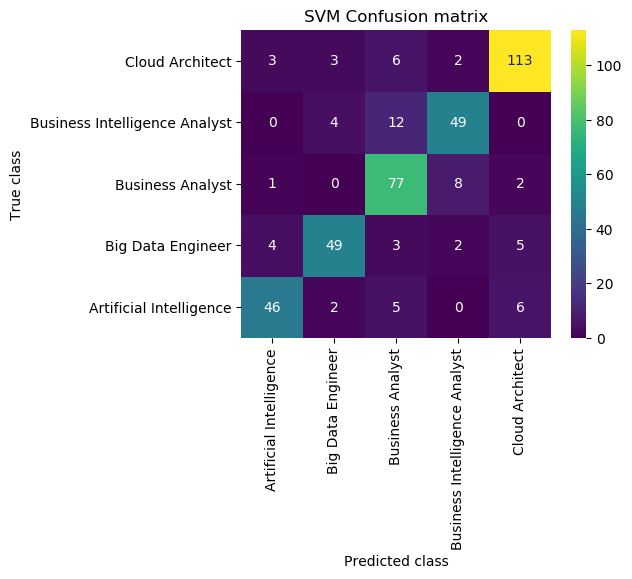

In [26]:
#now train SVM algorithm of TFIDF features
svm_cls = svm.SVC() #create SVM object
svm_cls.fit(tfidf_desc_X_train, tfidf_desc_y_train)#train SVM on training data
predict = svm_cls.predict(tfidf_desc_X_test) #predict on test data
calculateMetrics("SVM", predict, tfidf_desc_y_test)#calculate accuracy and other metrics

Naive Bayes Accuracy  : 51.49253731343284
Naive Bayes Precision   : 58.49931509238384
Naive Bayes Recall      : 50.15349052537095
Naive Bayes FMeasure    : 48.510212182038806


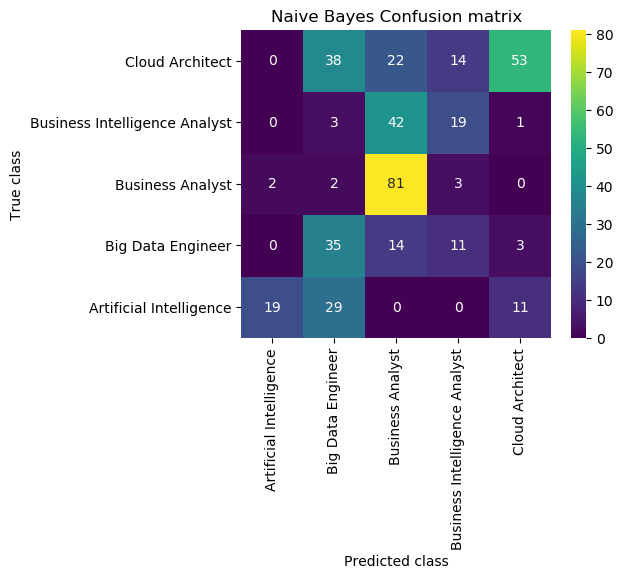

In [27]:
#now train naive bayes algorithm
nb_cls = GaussianNB() #create SVM object
nb_cls.fit(tfidf_desc_X_train, tfidf_desc_y_train)#train Naive Bayes on training data
predict = nb_cls.predict(tfidf_desc_X_test) #predict on test data
calculateMetrics("Naive Bayes", predict, tfidf_desc_y_test)#calculate accuracy and other metrics

Logistic Regression Accuracy  : 84.07960199004975
Logistic Regression Precision   : 84.35364584054878
Logistic Regression Recall      : 83.03320212862452
Logistic Regression FMeasure    : 83.4740598781666


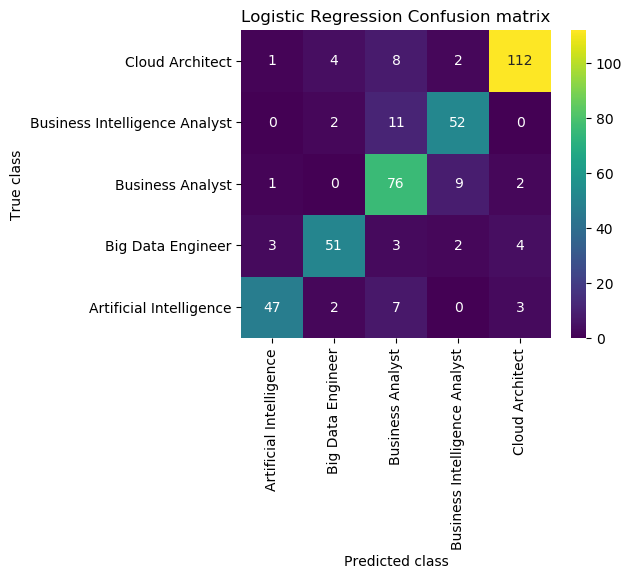

In [28]:
#now train Logistic Regression algorithm
lr_cls = LogisticRegression() #create LR object
lr_cls.fit(tfidf_desc_X_train, tfidf_desc_y_train)#train LR on training data
predict = lr_cls.predict(tfidf_desc_X_test) #predict on test data
calculateMetrics("Logistic Regression", predict, tfidf_desc_y_test)#calculate accuracy and other metrics

Propose BERT Model Accuracy  : 88.80597014925374
Propose BERT Model Precision   : 88.27245482672981
Propose BERT Model Recall      : 88.0964946557867
Propose BERT Model FMeasure    : 88.07212761226928


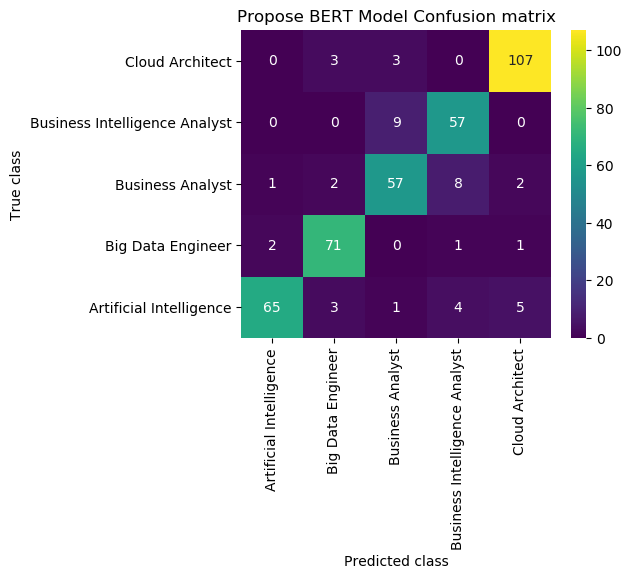

In [29]:
#train propose BERT model on BERT data using euclidean distance function to match predicted label with highest similarity
#to avoid incorrect prediction
predict = []
for i in range(len(bert_desc_X_test)):#loop all test data
    max_value = 0
    pred = 0
    for j in range(len(bert_desc_X)):#loop all bert train data
        #calculate euclidean distance between bert train and test data
        dst = dot(bert_desc_X_test[i], bert_desc_X[j]) / (norm(bert_desc_X_test[i]) * norm(bert_desc_X[j]))
        #choose predicted label with max similarity 
        if dst > max_value and dst != 1:
            max_value = dst
            pred = Y[j] 
    #save max similarity label in predict array        
    predict.append(pred)
calculateMetrics("Propose BERT Model", predict, bert_desc_y_test)#calculate accuracy and other metrics    



Extension CNN2d Model Accuracy  : 96.01990049751244
Extension CNN2d Model Precision   : 95.9826891519014
Extension CNN2d Model Recall      : 95.77199319854188
Extension CNN2d Model FMeasure    : 95.84152671930471


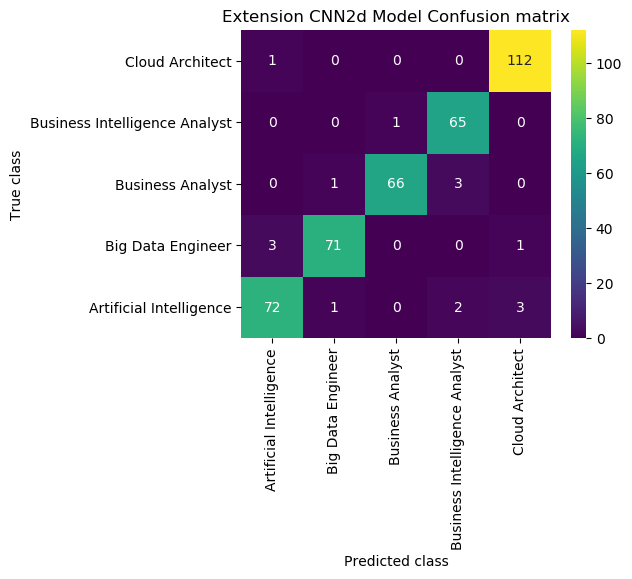

In [30]:
#now train extension CNN model using convolution 2D neural network as this algorithm filtered features at multiple
#neurons iterations to train model with best features and this best features help CNN in getting high accuracy
bert_desc_X_train = np.reshape(bert_desc_X_train, (bert_desc_X_train.shape[0], 10, 10, 3))
bert_desc_X_test = np.reshape(bert_desc_X_test, (bert_desc_X_test.shape[0], 10, 10, 3))
bert_desc_y_train = to_categorical(bert_desc_y_train)
bert_desc_y_test = to_categorical(bert_desc_y_test)
#define object
extension_model = Sequential()
#add CNN2d layer with 32 neurons to filter features 32 times
extension_model.add(Convolution2D(32, (3 , 3), input_shape = (bert_desc_X_train.shape[1], bert_desc_X_train.shape[2], bert_desc_X_train.shape[3]), activation = 'relu'))
#max layer collected filtered features from CNN layer
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
#defining another filter
extension_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
extension_model.add(Flatten())
#defining output layer
extension_model.add(Dense(units = 256, activation = 'relu'))
extension_model.add(Dense(units = bert_desc_y_train.shape[1], activation = 'softmax'))
#compile and train the model
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(bert_desc_X_train, bert_desc_y_train, batch_size = 16, epochs = 50, validation_data=(bert_desc_X_test, bert_desc_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model = load_model("model/cnn_weights.hdf5")
#perform prediction on test data   
predict = extension_model.predict(bert_desc_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(bert_desc_y_test, axis=1)
calculateMetrics("Extension CNN2d Model", predict, y_test1)#calculate accuracy and other metrics    

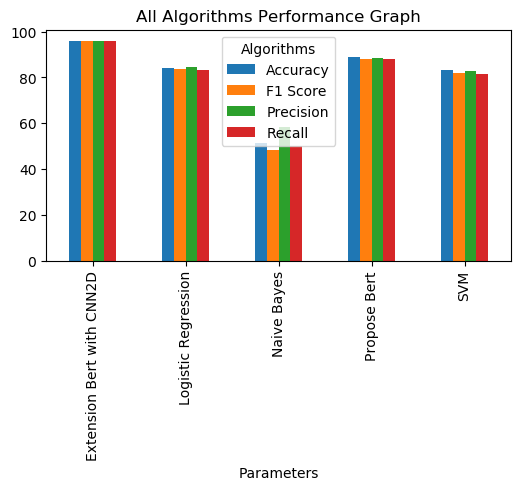

In [33]:
#all algorithms performance graph
df = pd.DataFrame([['SVM','Precision',precision[0]],['SVM','Recall',recall[0]],['SVM','F1 Score',fscore[0]],['SVM','Accuracy',accuracy[0]],
                   ['Naive Bayes','Precision',precision[1]],['Naive Bayes','Recall',recall[1]],['Naive Bayes','F1 Score',fscore[1]],['Naive Bayes','Accuracy',accuracy[1]],
                   ['Logistic Regression','Precision',precision[2]],['Logistic Regression','Recall',recall[2]],['Logistic Regression','F1 Score',fscore[2]],['Logistic Regression','Accuracy',accuracy[2]],
                   ['Propose Bert','Precision',precision[3]],['Propose Bert','Recall',recall[3]],['Propose Bert','F1 Score',fscore[3]],['Propose Bert','Accuracy',accuracy[3]],
                   ['Extension Bert with CNN2D','Precision',precision[4]],['Extension Bert with CNN2D','Recall',recall[4]],['Extension Bert with CNN2D','F1 Score',fscore[4]],['Extension Bert with CNN2D','Accuracy',accuracy[4]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar',figsize =(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [34]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["SVM", "Naive Bayes", "Logistic Regression", "Propose BERT", 'Extension BERT CNN2D']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,SVM,82.887127,81.520975,82.028356,83.084577
1,Naive Bayes,58.499315,50.153491,48.510212,51.492537
2,Logistic Regression,84.353646,83.033202,83.474060,84.079602
3,Propose BERT,88.272455,88.096495,88.072128,88.805970
4,Extension BERT CNN2D,95.982689,95.771993,95.841527,96.019900


In [35]:
#create bert object
bert = SentenceTransformer('nli-distilroberta-base-v2')
print("Bert model created")

Bert model created


In [46]:
#now predict job title from job description
dataset = pd.read_csv("Dataset/testData.csv",encoding = "ISO-8859-1")#read test data
dataset = dataset.values
for i in range(len(dataset)):#loop all jobs description
    data = dataset[i,0]
    data = cleanText(data)#clean job description
    temp = []
    temp.append(data)#add message to array
    embeddings = bert.encode(data, convert_to_tensor=True)#convert message review to bert vector
    X = embeddings.numpy()#convert vector to numpy
    X = X.reshape(1, -1)
    X = scaler1.transform(X)#normaize bert fetures
    X = selected1.transform(X)#select features using CHI2 selected objeect
    X = np.reshape(X, (X.shape[0], 10, 10, 3))
    predict = extension_model.predict(X)#now predict job title from job description features using extension model
    predict = np.argmax(predict)
    print("Job Description = "+dataset[i,0][0:150])
    print("PREDICTED JOB TITLE =====> "+class_label[predict]+"\n")#display output

Job Description = Note: By applying to this position your application is automatically submitted to the following locations: Los Angeles, CA, USA; Ann Arbor, MI, USA; C
PREDICTED JOB TITLE =====> Cloud Architect

Job Description = Overview Belstone is a fast-growing, technology-led merchant bank that drives capital to the private companies fueling economies, creating new jobs, a
PREDICTED JOB TITLE =====> Artificial Intelligence

Job Description = Marketing used to be an exercise in one-to-many communication: billboards, magazine ads, and - more recently - having a powerful social media presence
PREDICTED JOB TITLE =====> Big Data Engineer

Job Description = Job Title: Industrial Engineer - Data Operations Intern Reports To: Manager, Data Operations Department: Data Operations FLSA Status: Non-exempt Hours
PREDICTED JOB TITLE =====> Big Data Engineer

Job Description = OVERALL SUMMARY: Reports to the Senior Manager of Business Continuity and Crisis Management (BCCM). The BCCM Team help